In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
#import seaborn as sns
from sklearn.model_selection import KFold,GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics, preprocessing
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics import mean_absolute_error
import re
%matplotlib inline

## 1. Load Data

In [2]:
df_all = pd.read_excel('ML_data_FeatureImpute_0to40000.xlsx')

In [3]:
df_all.head()

,Unnamed: 0,sum_atomic_number,avg_atomic_number,diff_atomic_number,max_atomic_number,min_atomic_number,sum_atomic_weight,avg_atomic_weight,diff_atomic_weight,max_atomic_weight,...,max_thermal_conductivity,min_thermal_conductivity,band_gap,material_density,material_volume,volume_per_atom,space_group,pretty_formula,unit_cell_formula,cif
0,0,564,35.250000,5.336344,42,15,1275.295048,79.705940,12.842057,95.950000,...,124.372028,8.427902,0.0,8.991405,235.500240,14.718765,tetragonal,Mo3P,"{'P': 4.0, 'Mo': 12.0}",# generated using pymatgen\ndata_Mo3P\n_symmet...
1,1,180,45.000000,20.506097,74,16,431.800000,107.950000,53.662334,183.840000,...,173.000000,0.270000,0.0,11.056513,64.852032,16.213008,hexagonal,WS,"{'W': 2.0, 'S': 2.0}",# generated using pymatgen\ndata_WS\n_symmetry...
2,2,302,75.500000,2.474874,79,72,750.913138,187.728285,6.532454,196.966569,...,318.000000,23.000000,0.0,15.861590,78.612582,19.653145,tetragonal,HfAu,"{'Hf': 2.0, 'Au': 2.0}",# generated using pymatgen\ndata_HfAu\n_symmet...
3,3,256,64.000000,9.192388,77,51,627.954000,156.988500,24.910311,192.217000,...,147.000000,24.430000,0.0,13.028016,80.038446,20.009612,hexagonal,SbIr,"{'Sb': 2.0, 'Ir': 2.0}",# generated using pymatgen\ndata_SbIr\n_symmet...
4,4,680,23.448276,3.732348,30,5,1434.868000,49.478207,7.950313,65.380000,...,116.000000,27.400000,0.0,8.253692,288.696098,9.955038,cubic,Zn3(Ni10B3)2,"{'B': 6.0, 'Ni': 20.0, 'Zn': 3.0}",# generated using pymatgen\ndata_Zn3(Ni10B3)2\...


In [4]:
ml_all = df_all.drop(columns=['Unnamed: 0','pretty_formula','unit_cell_formula','cif'])

## 2. Drop target column and seperate columns into numerical and catogorical columns

In [5]:
data_types = ml_all.dtypes  
cat_cols = list(data_types[data_types=='object'].index)
con_cols = list(data_types[data_types=='int64'].index) + list(data_types[data_types=='float64'].index)
con_cols.remove('band_gap')
#con_cols.remove('min_boiling_point')

In [6]:
print ("Categorical features:", cat_cols)
print ( "Numerica features:", con_cols)

Categorical features: ['space_group']
Numerica features: ['sum_atomic_number', 'max_atomic_number', 'min_atomic_number', 'sum_period', 'max_period', 'min_period', 'max_covalent_radius', 'min_covalent_radius', 'sum_number_of_outer_shell_electrons', 'max_number_of_outer_shell_electrons', 'min_number_of_outer_shell_electrons', 'avg_atomic_number', 'diff_atomic_number', 'sum_atomic_weight', 'avg_atomic_weight', 'diff_atomic_weight', 'max_atomic_weight', 'min_atomic_weight', 'avg_period', 'diff_period', 'sum_group_id', 'avg_group_id', 'diff_group_id', 'max_group_id', 'min_group_id', 'sum_atomic_radius', 'avg_atomic_radius', 'diff_atomic_radius', 'max_atomic_radius', 'min_atomic_radius', 'sum_covalent_radius', 'avg_covalent_radius', 'diff_covalent_radius', 'sum_valence_electrons', 'avg_valence_electrons', 'diff_valence_electrons', 'max_valence_electrons', 'min_valence_electrons', 'avg_number_of_outer_shell_electrons', 'diff_number_of_outer_shell_electrons', 'sum_ionenergies', 'avg_ionenergie

## 3. One hot encoding

In [7]:
OHE = preprocessing.OneHotEncoder(sparse=True)
start=time.time()
full_data_sparse=OHE.fit_transform(ml_all[cat_cols])
print ('One-hot-encoding finished in %f seconds' % (time.time()-start))

One-hot-encoding finished in 0.025032 seconds


In [8]:
full_data_sparse

<40000x7 sparse matrix of type '<class 'numpy.float64'>'
	with 40000 stored elements in Compressed Sparse Row format>

In [9]:
full_data_sparse = sparse.hstack((full_data_sparse,ml_all[con_cols]), format='csr')
print (full_data_sparse.shape)

(40000, 95)


## 4. Train test split

In [10]:
train_x,test_x,train_y,test_y = train_test_split(full_data_sparse, ml_all['band_gap'], test_size=0.25, random_state=42)

## 5. Grid search

In [12]:
def logregobj(labels, preds):
    con = 2
    x =preds-labels
    grad =con*x / (np.abs(x)+con)
    hess =con**2 / (np.abs(x)+con)**2
    return grad, hess 

def log_mae(y,yhat):
    return mean_absolute_error(np.exp(y), np.exp(yhat))

log_mae_scorer = metrics.make_scorer(log_mae, greater_is_better = False)

In [23]:
def search_model(train_x, train_y, est, param_grid, n_jobs, cv, refit=False):
##Grid Search for the best model
    model = GridSearchCV(estimator  = est,
                                     param_grid = param_grid,
                                     scoring    = log_mae_scorer,
                                     verbose    = 10,
                                     n_jobs  = n_jobs,
                                     iid        = True,
                                     refit    = refit,
                                     cv      = cv)
    # Fit Grid Search Model
    model.fit(train_x, train_y)
    print("Best score: %0.3f" % model.best_score_)
    print("Best parameters set:", model.best_params_)
    print("Scores:", model.cv_results_)
    return model

In [ ]:
param_grid = {'objective':[logregobj],
              'learning_rate':[0.03,0.1,0.2],
              'n_estimators':[2000,4000,8000],
              'max_depth': [6,8,10],
              'min_child_weight':[10,8,6,4,2,1],
              'subsample': [0.78,0.5],
              'colsample_bytree':[0.67],
              'gamma':[0,0.9,10],
              'nthread': [-1],
              'seed' : [1234]}

model = search_model(train_x,
                     train_y,
                     xgb.XGBRegressor(),
                     param_grid,
                     n_jobs = 1,
                     cv = 4,
                     refit = True)

## 6. Model settings and fit model

In [ ]:
rgr = xgb.XGBRegressor(seed = 1234,
                       booster = 'gbtree',
                       learning_rate = 0.03, # smaller, better results, more time
                       n_estimators = 2000, # Number of boosted trees to fit.
                       max_depth=10, # the maximum depth of a tree
                       min_child_weight=10,
                       colsample_bytree=0.67, # the fraction of columns to be randomly samples for each tree
                       subsample=0.78, # the fraction of observations to be randomly samples for each tree
                       gamma=0.9, # Minimum loss reduction required to make a further partition on a leaf node of the tree, 
                       # the larger, the more conservative 
                       nthread = -1, # Number of parallel threads used to run xgboost.
                       silent = False # Whether to print messages while running boosting.
                      )
rgr.fit(train_x, train_y)

## 7. Make prediction

In [12]:
pred_y = rgr.predict(test_x)
for i in range(len(pred_y)):
    if pred_y[i] < 0:
        pred_y[i] = 0

In [13]:
results = pd.DataFrame()
#results['materials'] = df_all[train_size:]['pretty_formula']
results['pretty_formula'] = df_all.iloc[test_y.index]['pretty_formula']
results['band_gap'] = pred_y
results['real_band_gap'] = test_y.values
#results.to_excel("pred_20191131_5.xlsx", index=False)

In [14]:
mean_absolute_error(pred_y, test_y.values)

0.19816658614629265

In [15]:
mean_absolute_error(pred_y, test_y.values)/np.mean(test_y.values)

0.10041968272980022

In [16]:
pred_train_y = rgr.predict(train_x)

results = pd.DataFrame()
results['pretty_formula'] = df_all.iloc[train_y.index]['pretty_formula']
results['band_gap'] = pred_train_y
results['real_band_gap'] = train_y.values
#results.to_excel("pred_20191131_train.xlsx", index=False)
mean_absolute_error(pred_train_y, train_y.values)

0.0962918682367754

## 8. Feature Importance

In [21]:
impWeight = rgr.get_booster().get_score(importance_type='weight')
impGain = rgr.get_booster().get_score(importance_type='gain')
imp_out = {'feature':[],'importance_gain':[],'importance_weight':[]}
counter = 0
spaceGroup_imp_weight = 0
spaceGroup_imp_gain = 0
for index in impWeight:
    index_num = int(re.findall('\d+',index)[0])
    if index_num - 7 >= 0:
        key = con_cols[index_num-7] # space group takes 0 - 6 , so need to -7
        value_weight = impWeight[index]
        value_gain = impGain[index]
        imp_out['feature'].append(key)
        imp_out['importance_weight'].append(value_weight)
        imp_out['importance_gain'].append(value_gain)
    else:
        counter += 1
        spaceGroup_imp_weight += impWeight[index]
        spaceGroup_imp_gain += impGain[index]
        if counter == 7:
            imp_out['feature'].append('space_group')
            imp_out['importance_weight'].append(spaceGroup_imp_weight)
            imp_out['importance_gain'].append(spaceGroup_imp_gain)

In [22]:
pd.DataFrame(imp_out).to_excel('importance_summary_2.xlsx')

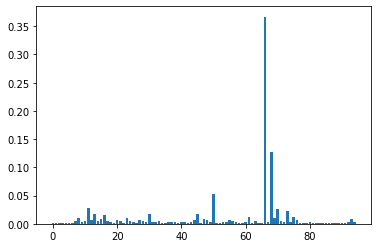

In [80]:
plt.bar(range(len(rgr.feature_importances_)), rgr.feature_importances_)
plt.show()

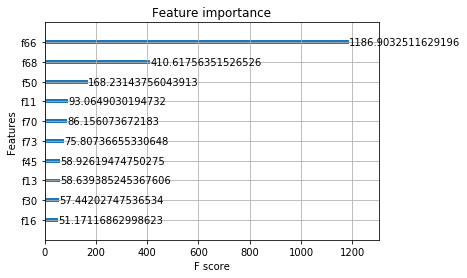

In [81]:
xgb.plot_importance(rgr,max_num_features=10,importance_type='gain')

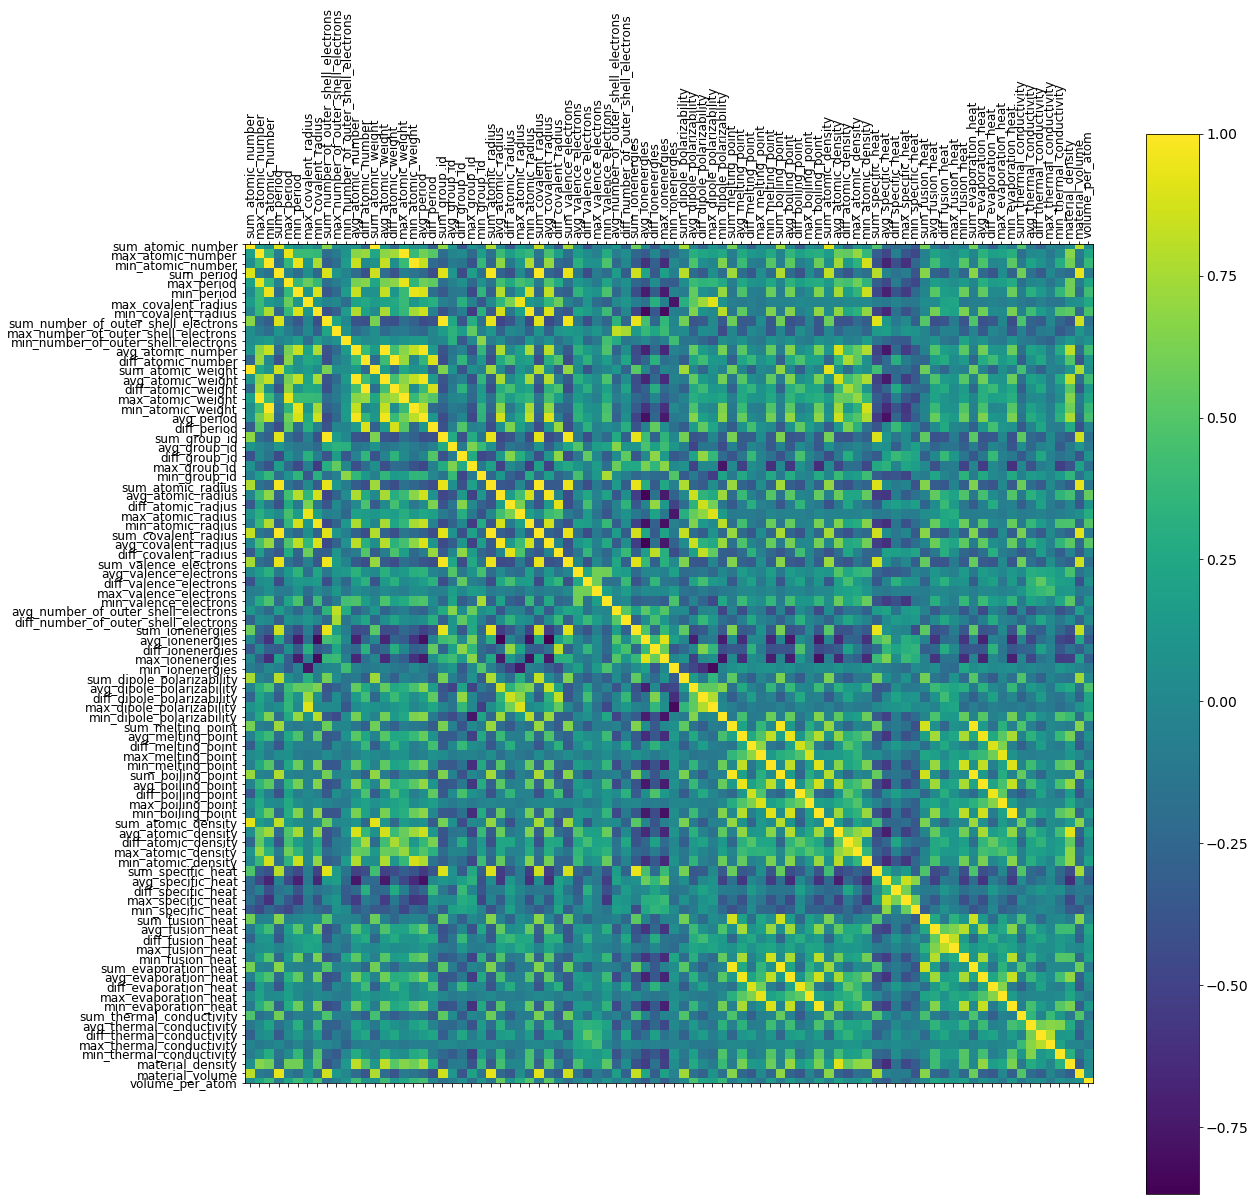

In [20]:
f = plt.figure(figsize=(19, 19))
plt.matshow(ml_all[con_cols].corr(), fignum=f.number)
plt.xticks(range(ml_all[con_cols].shape[1]), ml_all[con_cols].columns, fontsize=12,rotation=90)
plt.yticks(range(ml_all[con_cols].shape[1]), ml_all[con_cols].columns, fontsize=12)
#plt.savefig('FeatureCorr.png')
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#plt.title('Correlation Matrix', fontsize=16);